# DFA and Factor Investing

## HBS Case
### *Dimensional Fund Advisors, 2002 [HBS 9-203-026].

*Pages 1-5 of the case are required. Pages 6-11 get into interesting issues around trading (especially adverse selection) and tax considerations. These sections are useful for building market knowledge, but we will not cover them.**

# 2. The Factors

DFA believes certain stocks have higher expected excess returns. In addition to the overall market equity premium, DFA believes that there is a premium attached to a **size** and **value** factor. Note that these three factors are already listed as **excess** returns.

### Data
Use the data found in `data/dfa_analysis_data.xlsx`.

- Monthly **excess** return data for the overall equity market, $\tilde{r}^{\text{mkt}}$. 

- The sheet also contains data on two additional factors, `SMB` and `HML`, as well as the risk-free rate. 

- You do not need any of these columns for the homework. Just use the `MKT` column, which is **excess** market returns. (So no need to subtract the risk-free rate.)

#### Source:

Ken French library, accessible through the pandas-datareader API.

In [1]:
# import dask.dataframe as dd
# import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import statsmodels.api as sm

In [2]:
factors = pd.read_excel("../data/dfa_analysis_data.xlsx", sheet_name="factors", index_col=0, parse_dates=True)
factors.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07-31,0.0289,-0.0255,-0.0239,0.0022
1926-08-31,0.0264,-0.0114,0.0381,0.0025
1926-09-30,0.0038,-0.0136,0.0005,0.0023
1926-10-31,-0.0327,-0.0014,0.0082,0.0032
1926-11-30,0.0254,-0.0011,-0.0061,0.0031


### 1. The Factors

Calculate their univariate performance statistics: 

* mean
* volatility
* Sharpe
* VaR(.05)

Report these for the following three subsamples:

* Beginning - 1980
* 1981 - 2001
* 2002 - End


In [3]:
def performance_metrics(returns,annualization=1, quantile=.05):
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Mean'] = returns.mean() * annualization
    metrics['Vol'] = returns.std() * np.sqrt(annualization)
    metrics['Sharpe'] = (returns.mean() / returns.std()) * np.sqrt(annualization)

    metrics['Min'] = returns.min()
    metrics['Max'] = returns.max()
    return metrics

def maximum_drawdown(returns):
    cum_returns = (1 + returns).cumprod()
    rolling_max = cum_returns.cummax()
    drawdown = (cum_returns - rolling_max) / rolling_max

    max_drawdown = drawdown.min()
    end_date = drawdown.idxmin()
    summary = pd.DataFrame({'Max Drawdown': max_drawdown, 'Bottom': end_date})

    for col in drawdown:
        summary.loc[col,'Peak'] = (rolling_max.loc[:end_date[col],col]).idxmax()
        recovery = (drawdown.loc[end_date[col]:,col])
        try:
            summary.loc[col,'Recover'] = pd.to_datetime(recovery[recovery >= 0].index[0])
        except:
            summary.loc[col,'Recover'] = pd.to_datetime(None)

        summary['Peak'] = pd.to_datetime(summary['Peak'])
        try:
            summary['Duration (to Recover)'] = (summary['Recover'] - summary['Peak'])
        except:
            summary['Duration (to Recover)'] = None
            
        summary = summary[['Max Drawdown','Peak','Bottom','Recover','Duration (to Recover)']]

    return summary    


def tail_metrics(returns, quantile=.05, relative=False, mdd=True):
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Skewness'] = returns.skew()
    metrics['Kurtosis'] = returns.kurtosis()

    VaR = returns.quantile(quantile)
    CVaR = (returns[returns < returns.quantile(quantile)]).mean()

    if relative:
        VaR = (VaR - returns.mean())/returns.std()
        CVaR = (CVaR - returns.mean())/returns.std()

    metrics[f'VaR ({quantile})'] = VaR
    metrics[f'CVaR ({quantile})'] = CVaR

    if mdd:
        mdd_stats = maximum_drawdown(returns)
        metrics = metrics.join(mdd_stats)

        if relative:
            metrics['Max Drawdown'] = (metrics['Max Drawdown'] - returns.mean())/returns.std()

    return metrics

In [4]:
FIRST_END = "1980"
MID_START, MID_END = "1981", "2001"
LAST_START = "2002"

beg_metrics = performance_metrics(factors.loc[:FIRST_END], annualization=12)
beg_tail = tail_metrics(factors.loc[:FIRST_END], quantile=.05, relative=True)
beg_df = pd.concat([beg_metrics, beg_tail], axis=1)
beg_df['Period'] = "1926-1980"

mid_mask = (factors.index >= MID_START) & (factors.index <= MID_END)
mid_metrics = performance_metrics(factors.loc[mid_mask], annualization=12)
mid_tail = tail_metrics(factors.loc[mid_mask], quantile=.05, relative=True)
mid_df = pd.concat([mid_metrics, mid_tail], axis=1)
mid_df['Period'] = "1981-2001"

end_mask = (factors.index >= LAST_START)
end_metrics = performance_metrics(factors.loc[end_mask], annualization=12)
end_tail = tail_metrics(factors.loc[end_mask], quantile=.05, relative=True)
end_df = pd.concat([end_metrics, end_tail], axis=1)
end_df['Period'] = "2002-Present"

# Set up a hierarchical MultiIndex: first level = Period, second = Factor
beg_df = beg_df.reset_index().set_index(['Period', 'index'])
mid_df = mid_df.reset_index().set_index(['Period', 'index'])
end_df = end_df.reset_index().set_index(['Period', 'index'])

# Combine all periods into one DataFrame
stacked_hier = pd.concat([beg_df, mid_df, end_df], axis=0)
stacked_hier.index.names = ['Period', 'Factor']

# get only mean, vol, sharpe, VaR(.05) for display
display_df = stacked_hier[['Mean', 'Vol', 'Sharpe', 'VaR (0.05)']]
display(display_df)

Mean       Vol    Sharpe  VaR (0.05)
Period       Factor                                          
1926-1980    Mkt-RF  0.080958  0.204988  0.394938   -1.535047
             SMB     0.033914  0.114277  0.296769   -1.355040
             HML     0.050321  0.134228  0.374893   -1.250080
             RF      0.027730  0.007673  3.614032   -1.043281
1981-2001    Mkt-RF  0.088500  0.153881  0.575119   -1.513676
             SMB    -0.011565  0.115281 -0.100320   -1.296812
             HML     0.059710  0.104929  0.569052   -1.476900
             RF      0.064355  0.007720  8.336005   -1.284621
2002-Present Mkt-RF  0.091306  0.153529  0.594711   -1.915017
             SMB     0.007931  0.088448  0.089669   -1.560981
             HML     0.001204  0.106442  0.011313   -1.353373
             RF      0.015837  0.005213  3.038090   -0.877021


### 2. 

Based on the factor statistics above, answer the following.

- Does each factor have a premium (positive expected excess return) in each subsample?

- Does the premium to the size factor get smaller after 1980?

- Does the premium to the value factor get smaller during the 1990's?

- How have the factors performed since the time of the case, (2002-present)?


We can see that SMB did not have a premium from 1981 to 2001, with a negative mean.

This makes the premium negative and thus quite smaller after 1980 than it was between 1926 and 1980. It also does not recover to the same level past 2001.

The value factor gets a slightly larger premium in the 1981-2001 period, before getting much smaller from 2002.

Both size and value have had lower returns since 2002 than they did before 1980, though size went from negative returns back to positive.

### 3.

The factors are constructed in such a way as to reduce correlation between them.

* Report the correlation matrix across the three factors. 

* Does the construction method succeed in keeping correlations small? 

* Does it achieve this in each subsample?


In [5]:
factors.corr()

,Mkt-RF,SMB,HML,RF
Mkt-RF,1.000000,0.320443,0.227832,-0.064118
SMB,0.320443,1.000000,0.125828,-0.053054
HML,0.227832,0.125828,1.000000,0.017634
RF,-0.064118,-0.053054,0.017634,1.000000


Over the entire sample, correlations are indeed small between factors.

In [6]:
# get correlation matrix of factors for each subsample period
first_sample = factors.loc[:FIRST_END]
mid_sample = factors.loc[MID_START:MID_END]
last_sample = factors.loc[LAST_START:]

print(f"First sample: {FIRST_END}")
display(first_sample.corr())
print(f"Mid sample: {MID_START} - {MID_END}")
display(mid_sample.corr())
print(f"Last sample: {LAST_START}")
display(last_sample.corr())

First sample: 1980


,Mkt-RF,SMB,HML,RF
Mkt-RF,1.000000,0.374234,0.442341,-0.070425
SMB,0.374234,1.000000,0.313397,-0.036546
HML,0.442341,0.313397,1.000000,-0.029839
RF,-0.070425,-0.036546,-0.029839,1.000000


Mid sample: 1981 - 2001


,Mkt-RF,SMB,HML,RF
Mkt-RF,1.000000,0.158652,-0.529912,-0.111632
SMB,0.158652,1.000000,-0.445451,-0.052500
HML,-0.529912,-0.445451,1.000000,0.092622
RF,-0.111632,-0.052500,0.092622,1.000000


Last sample: 2002


,Mkt-RF,SMB,HML,RF
Mkt-RF,1.000000,0.316034,0.109671,-0.038395
SMB,0.316034,1.000000,0.116227,-0.104764
HML,0.109671,0.116227,1.000000,-0.037115
RF,-0.038395,-0.104764,-0.037115,1.000000


Interestingly, the lowest factor correlations are in the 2002-present period. HML in particular had significant correlations with market beta in both 1926-1980 and 1981-2001 subsamples.

### 4. 

* Plot the cumulative returns of the three factors. 

* Create plots for the 1981-2001 subsample as well as the 2002-Present subsample.


<Axes: xlabel='Date'>

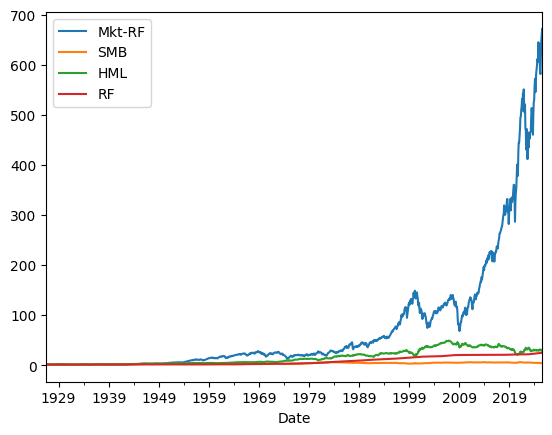

In [7]:
base = factors + 1
base.cumprod().plot()

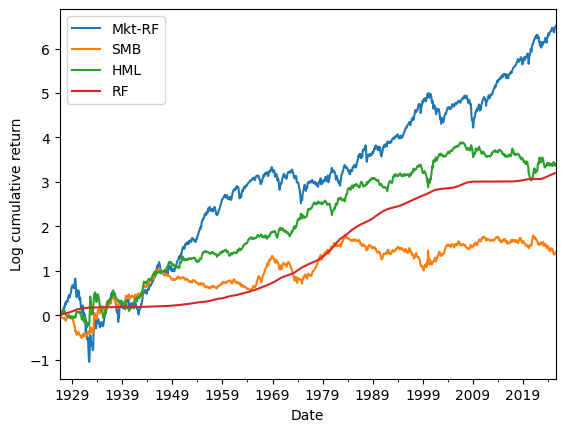

In [8]:
# logplot of cumulative returns of factors
ax = (base.cumprod().apply(np.log)).plot()
ax.set_ylabel('Log cumulative return')
plt.show()

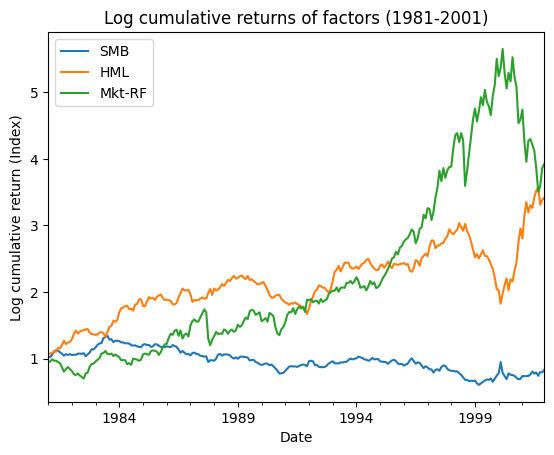

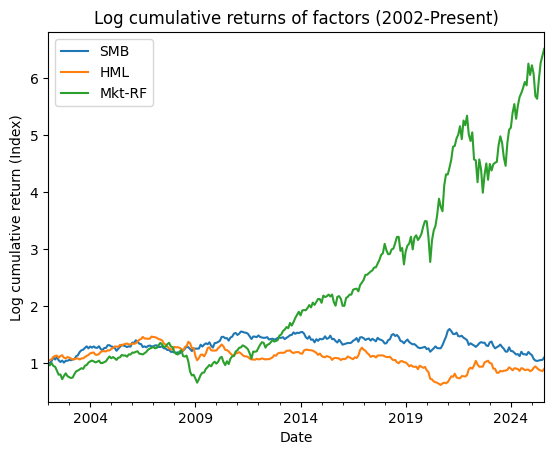

In [9]:
# plot of the three factors for 1981-2001
ax1 = base[['SMB', 'HML', 'Mkt-RF']].loc[MID_START:MID_END].cumprod().plot()
ax1.set_ylabel('Log cumulative return (Index)')
ax1.set_title('Log cumulative returns of factors (1981-2001)')
plt.show()

# plot of the three factors for 2002-present
ax2 = base[['SMB', 'HML', 'Mkt-RF']].loc[LAST_START:].cumprod().plot()
ax2.set_ylabel('Log cumulative return (Index)')
ax2.set_title('Log cumulative returns of factors (2002-Present)')
plt.show()


### 5.

* Does it appear that all three factors were valuable in 1981-2001? 
* And post-2001? 

Would you advise DFA to continue emphasizing all three factors?

The size factor underperformed and had negative excess return over the 1981-2001 period, and very slight positive return post-2001. While the value factor was valuable in 1981-2001, it converged to the size factor's performance post-2001.

Market beta performed well in both periods, though it must be noted it underperformed for most of teh decade post 2001 before rising significantly in the 2010s.

It does seem like DFA invested in these factors when they were clear academic signals, but their publication has eroded excess returns since.

# 3. CAPM

DFA believes that premia in stocks and stock portfolios is related to the three factors. 

Let's test `25` equity portfolios that span a wide range of size and value measures.

#### Footnote
For more on the portfolio construction, see the description at Ken French's data library. 
https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/tw_5_ports.html

#### Portfolios
Monthly **total** return data on `25` equity portfolios sorted by their size-value characteristics. Denote these as $\vec{r}^{i}$, for $n=1, \ldots, 25$.
- Note that while the factors were given as excess returns, the portfolios are total returns.
- For this entire problem, focus on the 1981-Present subsample.

### 1. Summary Statistics. 

For each portfolio, 
- Use the Risk-Free rate column in the factors tab to convert these total returns to excess returns.
- Calculate the (annualized) univariate statistics from `1.1`.

In [10]:
pf_data = pd.read_excel("../data/dfa_analysis_data.xlsx", sheet_name="portfolios (total returns)", index_col=0, parse_dates=True)
pf_data.head()

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
Date,,,,,,,,,,,,,,,,,,,,,
1926-07-31,0.058276,-0.017006,0.005118,-0.021477,0.019583,0.012118,0.024107,0.006056,-0.026082,-0.004527,...,0.015376,0.015460,0.013389,0.002765,0.024678,0.033248,0.060909,0.020285,0.031263,0.005623
1926-08-31,-0.020206,-0.080282,0.013968,0.021483,0.085104,0.023620,-0.007525,0.038984,0.002299,0.062937,...,0.013858,0.038587,0.019738,0.021336,0.053422,0.010169,0.041975,0.019769,0.054924,0.077576
1926-09-30,-0.048291,-0.026806,-0.043417,-0.032683,0.008586,-0.026849,-0.005252,0.010789,-0.032877,-0.009419,...,0.016897,-0.005246,-0.017724,0.014806,0.008730,-0.012951,0.036610,0.001384,-0.007497,-0.024284
1926-10-31,-0.093633,-0.035519,-0.035024,0.034413,-0.025452,-0.028014,-0.044191,-0.050767,-0.080271,-0.013213,...,-0.039136,-0.026528,-0.021058,-0.032532,-0.053525,-0.027382,-0.030061,-0.022467,-0.046725,-0.058129
1926-11-30,0.055888,0.041877,0.024384,-0.044495,0.005110,0.031023,-0.017317,0.030425,0.049538,0.027292,...,0.034492,0.023823,0.037315,0.051102,0.018213,0.044331,0.025355,0.015280,0.036596,0.025636


In [11]:
# use RF column to convert to excess returns
pf_data = pf_data.sub(factors['RF'], axis=0)
pf_data.head()

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
Date,,,,,,,,,,,,,,,,,,,,,
1926-07-31,0.056076,-0.019206,0.002918,-0.023677,0.017383,0.009918,0.021907,0.003856,-0.028282,-0.006727,...,0.013176,0.013260,0.011189,0.000565,0.022478,0.031048,0.058709,0.018085,0.029063,0.003423
1926-08-31,-0.022706,-0.082782,0.011468,0.018983,0.082604,0.021120,-0.010025,0.036484,-0.000201,0.060437,...,0.011358,0.036087,0.017238,0.018836,0.050922,0.007669,0.039475,0.017269,0.052424,0.075076
1926-09-30,-0.050591,-0.029106,-0.045717,-0.034983,0.006286,-0.029149,-0.007552,0.008489,-0.035177,-0.011719,...,0.014597,-0.007546,-0.020024,0.012506,0.006430,-0.015251,0.034310,-0.000916,-0.009797,-0.026584
1926-10-31,-0.096833,-0.038719,-0.038224,0.031213,-0.028652,-0.031214,-0.047391,-0.053967,-0.083471,-0.016413,...,-0.042336,-0.029728,-0.024258,-0.035732,-0.056725,-0.030582,-0.033261,-0.025667,-0.049925,-0.061329
1926-11-30,0.052788,0.038777,0.021284,-0.047595,0.002010,0.027923,-0.020417,0.027325,0.046438,0.024192,...,0.031392,0.020723,0.034215,0.048002,0.015113,0.041231,0.022255,0.012180,0.033496,0.022536


In [12]:
# calculate univariate statistics
pf_metrics = performance_metrics(pf_data, annualization=12)
pf_tail = tail_metrics(pf_data, quantile=.05, relative=False)
pf_df = pd.concat([pf_metrics, pf_tail], axis=1)

# get only mean, vol, sharpe, VaR(.05) for display
display_df = pf_df[['Mean', 'Vol', 'Sharpe', 'VaR (0.05)']]
display(display_df)

,Mean,Vol,Sharpe,VaR (0.05)
SMALL LoBM,0.068285,0.412683,0.165465,-0.142903
ME1 BM2,0.079138,0.334279,0.236743,-0.128362
ME1 BM3,0.117213,0.306450,0.382487,-0.104112
ME1 BM4,0.135062,0.286639,0.471192,-0.102063
SMALL HiBM,0.160757,0.317360,0.506545,-0.113591
ME2 BM1,0.077413,0.275990,0.280493,-0.111098
ME2 BM2,0.110993,0.258963,0.428606,-0.096367
ME2 BM3,0.115222,0.250012,0.460867,-0.092983
ME2 BM4,0.124235,0.257403,0.482649,-0.093828
ME2 BM5,0.147626,0.300293,0.491607,-0.112550


### 2. CAPM

The Capital Asset Pricing Model (CAPM) asserts that an asset (or portfolio's) expected excess return is completely a function of its beta to the equity market index (`SPY`, or in this case, `MKT`.) 

Specifically, it asserts that, for any excess return, $\tilde{r}^{i}$, its mean is proportional to the mean excess return of the market, $\tilde{r}^{\text{mkt}}$, where the proporitonality is the regression beta of $\tilde{r}^{i}$ on $\tilde{r}^{\text{mkt}}$.

$$
\mathbb{E}\left[\tilde{r}_{t}^{i}\right] = \beta^{i,\text{mkt}}\; \mathbb{E}\left[\tilde{r}_{t}^{\text{mkt}}\right]
$$

Let's examine whether that seems plausible.

For each of the $n=25$ test portfolios, run the CAPM time-series regression:

$$
\tilde{r}_{t}^{i} = \alpha^i + \beta^{i,\text{mkt}}\; \tilde{r}_{t}^{\text{mkt}} + \epsilon_{t}^{i}
$$

So you are running 25 separate regressions, each using the $T$-sized sample of time-series data.

* Report the betas and alphas for each test asset.

* Report the mean-absolute-error of the CAPM:
$$\text{MAE} = \frac{1}{n}\sum_{i=1}^n \left|\alpha_i\right|$$

If the CAPM were true, what would we expect of the MAE?

- Report the estimated $\beta^{i,\text{mkt}}$, Treynor Ratio, $\alpha^i$, and Information Ratio for each of the $n$ regressions.

- If the CAPM model were true, what would be true of the Treynor Ratios, alphas, and Information Ratios?

In [13]:
# run the CAPM time-series regressions for each portfolio
import warnings
warnings.filterwarnings('ignore')

betas = {}
alphas = {}
for portfolio in pf_data.columns:
    y = pf_data[portfolio]
    X = factors['Mkt-RF']
    X = sm.add_constant(X)
    results = sm.OLS(y, X).fit()
    # store betas and alphas
    betas[portfolio] = results.params[0]
    alphas[portfolio] = results.params[1]

# display betas and alphas
betas_alphas_df = pd.concat([pd.DataFrame(betas, index=['beta']), pd.DataFrame(alphas, index=['alpha'])])
display(betas_alphas_df)

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
beta,-0.005362,-0.003013,0.000392,0.002532,0.004012,-0.002310,0.000754,0.001321,0.001967,0.002805,...,-0.000192,0.000234,0.000766,0.001662,0.000696,0.000267,-0.000021,0.000401,-0.000862,0.000611
alpha,1.602311,1.392971,1.359342,1.264748,1.360529,1.270198,1.231694,1.200621,1.215841,1.376946,...,1.088075,1.091024,1.102468,1.162114,1.390745,0.961275,0.945731,0.966804,1.097705,1.300017


In [14]:
# compute MAE
mae = np.mean(np.abs(betas_alphas_df.loc['alpha']))
print(f"MAE: {mae}")
# compute Treynor and Information ratios
treynor_ratios = betas_alphas_df.loc['beta'] / pf_metrics['Vol']
information_ratios = betas_alphas_df.loc['alpha'] / pf_metrics['Vol']
combined_ratios = pd.DataFrame([treynor_ratios, information_ratios], 
                               index=['Treynor ratio', 'Information ratio'])
display(combined_ratios)

MAE: 1.2162102560810957


,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
Treynor ratio,-0.012992,-0.009014,0.001278,0.008832,0.012643,-0.008370,0.002911,0.005282,0.007641,0.009340,...,-0.000896,0.001109,0.003513,0.007036,0.002349,0.001446,-0.000117,0.002074,-0.003813,0.002086
Information ratio,3.882669,4.167087,4.435773,4.412339,4.287014,4.602343,4.756247,4.802243,4.723501,4.585348,...,5.074367,5.165560,5.057073,4.921244,4.692807,5.199328,5.197977,5.006918,4.855097,4.440248


The reported MAE is considerable, above 1.20.
If the CAPM were true, we'd expect _all_ alphas to be close to zero and betas to be high. Yet this is the opposite of what we see here!
Treynor ratios are very low while IRs are conversely very high. CAPM would predict the opposite.

### 3. Cross-sectional Estimation

Let's test the CAPM directly. We already have what we need:

- The dependent variable, (y): mean excess returns from each of the $n=25$ portfolios.
- The regressor, (x): the market beta from each of the $n=25$ time-series regressions.

Then we can estimate the following equation:

$$
\underbrace{\mathbb{E}\left[\tilde{r}^{i}\right]}_{n\times 1\text{ data}} = \textcolor{ForestGreen}{\underbrace{\eta}_{\text{regression intercept}}} + \underbrace{{\beta}^{i,\text{mkt}};}_{n\times 1\text{ data}}~ \textcolor{ForestGreen}{\underbrace{\lambda_{\text{mkt}}}_{\text{regression estimate}}} + \textcolor{ForestGreen}{\underbrace{\upsilon}_{n\times 1\text{ residuals}}}
$$

Note that
- we use sample means as estimates of $\mathbb{E}\left[\tilde{r}^{i}\right]$. 
- this is a weird regression! The regressors are the betas from the time-series regressions we already ran!
- this is a single regression, where we are combining evidence across all $n=25$ series. Thus, it is a cross-sectional regression!
- the notation is trying to emphasize that the intercept is different than the time-series $\alpha$ and that the regressor coefficient is different than the time-series betas.

Report
- the R-squared of this regression.
- the intercept, $\eta$. 
- the regression coefficient, $\lambda_{\text{mkt}}$.

What would these three statistics be if the CAPM were completely accurate?

In [15]:
# run the cross-sectional CAPM regression
X = betas_alphas_df.loc['beta'] # regressors are betas from time-series regressions
y = pf_metrics['Mean'] # dependent variable is mean excess return
X = sm.add_constant(X) # add constant regression intercept
results = sm.OLS(y, X).fit()
display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Mean   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     60.17
Date:                Sun, 26 Oct 2025   Prob (F-statistic):           7.25e-08
Time:                        13:34:42   Log-Likelihood:                 74.308
No. Observations:                  25   AIC:                            -144.6
Df Residuals:                      23   BIC:                            -142.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1014      0.003     38.179      0.000       0.096       0.107
beta          10.4461      1.347      7.757      0.000       7.660      13.232
==============================================================================
Omnibus:                        0.691   Durbin-Watson:                   1.088
Prob(Omnibus):                  0.708   Jarque-Bera (JB):                0.690
Skew:                          -0.118   Prob(JB):                        0.708
Kurtosis:                       2.221   Cond. No.                         521.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
print(f"R-squared: {results.rsquared}")
print(f"Intercept: {results.params[0]}")
print(f"Regression coefficient: {results.params[1]}")

R-squared: 0.7234648571800251
Intercept: 0.10137811872591768
Regression coefficient: 10.446140563193437


If the CAPM were completely accurate, the intercept and residuals would be 0 and R-squared would be 1. Alas, the intercept is 0.1 and R-squared captures only 72% of variance.

### 4. Conclusion

Broadly speaking, do these results support DFA's belief in size and value portfolios containing premia unrelated to the market premium?

These results are mixed. Much of the variance of these portfolios is explained by the market premium, though not all of it. The existence of the premia themselves might come into question, considering the diminished returns post-2001 of both factors.